In [1]:
import numpy as np
from matplotlib import pyplot as plt
import time
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
from scipy.interpolate import RectBivariateSpline
from module.interpolate import Interpolator

---

Plastic pollution in the ocean is a worldwide discussed topic because the consequences are disruptive for the environment, causing ecosystem disruption and posing a threat to marine life and human health. This settles why it is crucial to understand the dynamics of plastic particle transport in the ocean. By implementing the Langrangian particle method it is possible to predict where plastic particles will end up from their initial release into the ocean, which in turn will give us a better overview and therefore it will be easier to initiate countermeasures. 

The Langrangian method consists of representing the plastic particles as numerical particles and simulating the individual particles trajectories as they are traveling with the flow. The result is a simulation that calculates the probability of finding particles at specific locations after a given time. We do not need to model the fluid itself, as this information is simulated by the Meteorological Institute. In turn, we access a more detailed and accurate understanding of the movements and properties of the particles.

# Problem 1


## ( 1-a )
- We will first consider a single particle starting from an initial position $x_0 = [1.05,0.5]$. 
- Let the trajectory, x(t), of the particle be controlled by Eqs. (3) and (4). Calculate the trajectory for the time interval $ t_1 \in [0, 50]$,  using Heun’s method.
- Try a few different timesteps, and compare the results by plotting the trajectories for different timesteps in the same plot. Make up your mind about what seems a reasonably short timestep. 
- What happens if you double the integration time, such that $ t_2 \in [0, 100]$, is the same timestep still a good choice?



In [2]:
from module.utilities import run_steplength_test
from module.interpolate import velocity

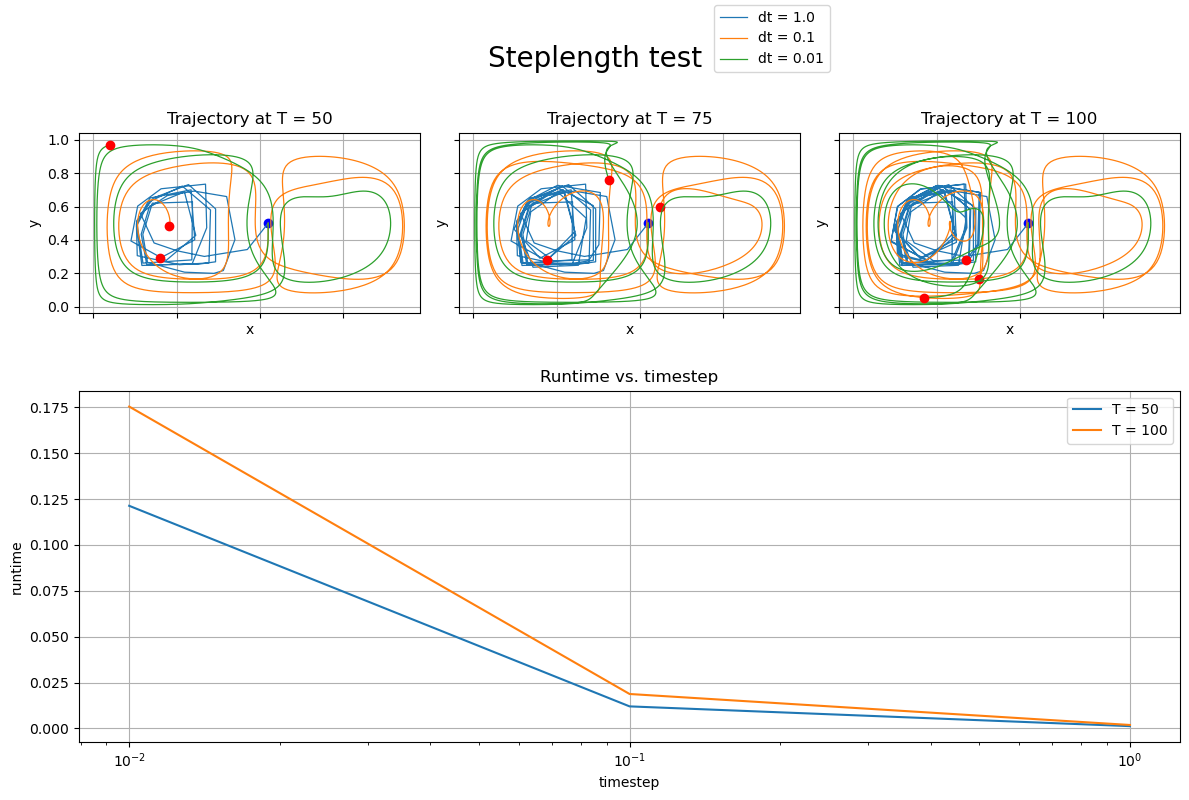

In [3]:
scatter_final_parameters = {"s": 5}
plot_parameters = {"alpha":1, "linewidth":0.9}

X0 = np.array([[1.05], [0.50]])
time_testvalues = np.array([50, 75, 100])
dt_testvalues = np.array([1, 0.1, 0.01])

fig, ax = plt.subplots(2, len(time_testvalues), figsize=(12, 8), sharex=True, sharey=True)
ax[1, 0].remove()
ax[1, 1].remove()
ax[1, 2].remove()

ax[0, :], time_array = run_steplength_test(ax[0, :], velocity, X0, time_testvalues=time_testvalues, stepsize_testvalues=dt_testvalues, **plot_parameters)
bottom_ax = fig.add_subplot(212)
bottom_ax.plot(dt_testvalues, time_array[0, :], label="T = 50")
bottom_ax.plot(dt_testvalues, time_array[1, :], label="T = 100")
bottom_ax.set_xscale("log")
bottom_ax.set_title("Runtime vs. timestep")
bottom_ax.set_xlabel("timestep")
bottom_ax.set_ylabel("runtime")
bottom_ax.grid()
bottom_ax.legend()
fig.suptitle("Steplength test", fontsize=20, y = 0.95, x=0.5)
fig.legend(*ax[0, 0].get_legend_handles_labels(), loc=[0.6, 0.91])
plt.tight_layout(rect=[0, 0, 1, 1.02])
plt.show()

## ( 1-b )

For the first time interval $t \in [0, 50]$, the time-step $t = 0.1$ seems to be suffiecient to represent the particle.
For the time interval $t \in [0, 100]$, $t = 0.1$ deviates more from the shorter time steps, and is not short enough to represent the particle path correctly. With $t = 0.01$ however, is a better approximation, when comparing to the smaller timestep. 

Regarding the runtime, the biggest reduction happens when increasing $dt$ from 0.001 to 0.01. The graph shows a double in runtime when the time interval doubles, i.e. runtime is proportional to array length when using numpy arrays. For the time intervals tested here, the length of the arrays is not long enough for $dt$ to have a remarkable impact on runtime. For calculations going over several days, which will be the case later in the rapport, $dt$ will have to be significantly bigger.

Due to the significant reduction in runtime, $t = 0.01$ is the most economic timestep for these calculations.


In [4]:
from module.trajectory import Trajectory
trajectory_parameters = {"time_interval": [0, 10],"number_of_particles": 100,"stepsize": 0.1,"mode": "grid", "location": [-0.1, 0.1],"scale": 0.1}
traj = Trajectory(**trajectory_parameters)
traj(velocity)
traj.info()

Trajectory with:
Np: 100 particles
Time: [0, 10]
Time step: 0.1
Initial position: [-0.1 -0.1]
Mode: grid
Check land: False
Velocity shape: (100, 100)
X, Y shape: (100, 100)
U, V shape: (100, 100)
xmin: -1.3172459550054354, xmax: 1.1419887431678815
ymin: -0.9971581621764161, ymax: 0.9971581621764161
Distance mean: 1.736579968899405


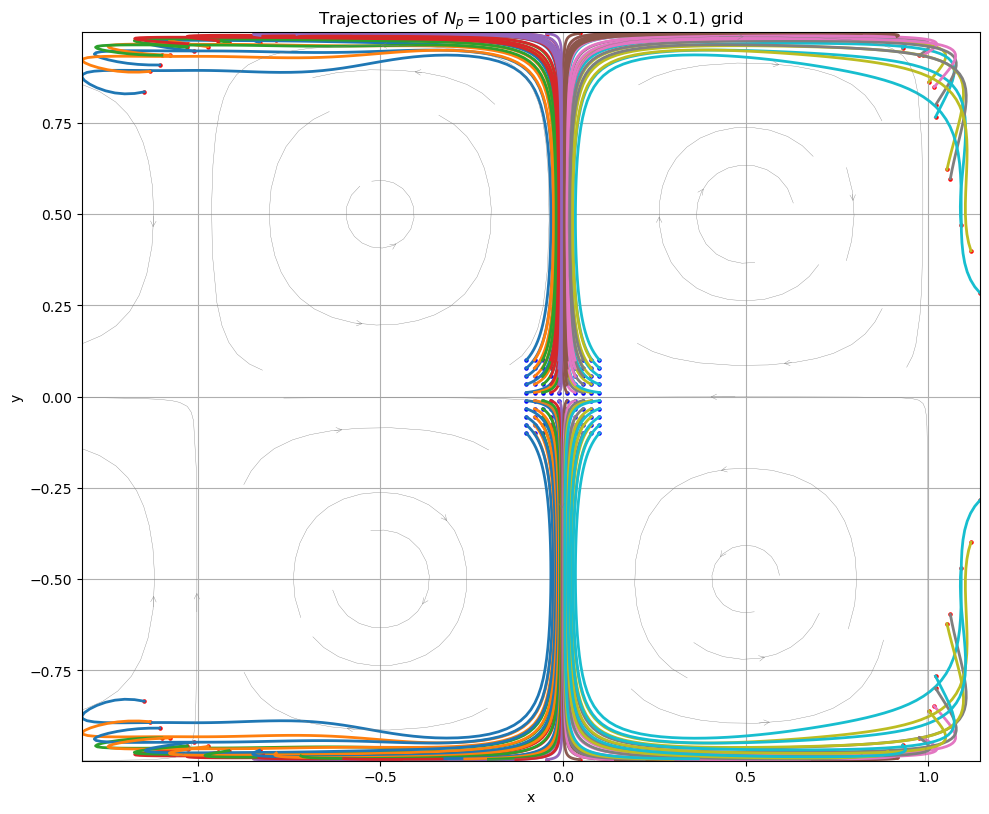

In [5]:
streamplot_parameters = {"color": "grey","density": 0.5,"linewidth": 0.25,"arrowsize": 1,"arrowstyle": "->"}
scatter_initial_parameters = {"s": 5, "c": "blue", "marker": "o", "label": "Initial position"}
scatter_final_parameters = {"s": 5, "c": "red", "marker": "o", "label": "Final position"}
plot_parameters = {"alpha":1, "linewidth":2}

fig, ax = plt.subplots(1, 1, figsize=(8, 5))

traj.plot(ax, **plot_parameters)
traj.streamplot(ax, **streamplot_parameters)
traj.scatter(ax, t=0, **scatter_initial_parameters)
traj.scatter(ax, t=-1, **scatter_final_parameters)

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title(f"Trajectories of $N_p = 100$ particles in $(0.1\\times 0.1)$ grid")
plt.grid()
plt.tight_layout()

plt.show()

Depending on the initial position of each particle, here only separated by a distance of 0.01 units, takes different paths. The time interval is here limited to $t \in [0, 10]$ The streamlines represent the velocity field at $t=0$ to give an idea of the impact of the current and wind. This will change with time, but keeps somewhat the same shape. The particles on the further right are caught by the streams to the right, and similarly on the left side. 

## ( 1-c )


<Figure size 750x500 with 0 Axes>

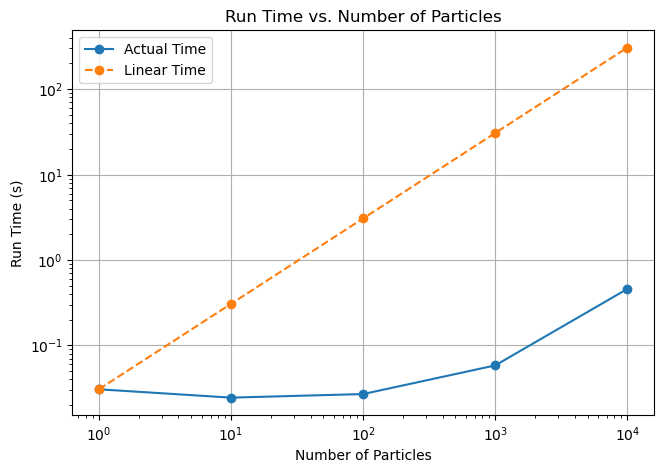

In [6]:
from module.utilities import run_timing_test
import numpy as np

dt = 0.01
time_interval = [0, 10]
Np_testvalues = [1, 10, 100, 1000, 10_000]
times, linear_times = run_timing_test(interpolator=velocity, number_of_particles_testvalues = Np_testvalues, time_interval = time_interval, stepsize=0.01)

fig, ax = plt.subplots(figsize=(7.5, 5))

ax.plot(Np_testvalues, times, marker="o", label="Actual Time")
ax.plot(Np_testvalues, linear_times, marker="o", linestyle="--", label="Linear Time")

ax.set_title("Run Time vs. Number of Particles")
ax.set_xlabel("Number of Particles")
ax.set_ylabel("Run Time (s)")
ax.set_xscale("log")
ax.set_yscale("log")
ax.legend()
plt.grid(True)
plt.show()


The graph shows the curve is approximately constant for fewer particles, i.e. shorter arrays. For few particles, the linear increase may be too little to measure. The overhead time, in this case, is the time that python and jupyter cell/kernel uses as preparation for executing the task at hand. This overhead time can be few milliseconds, meaning if the running time of the numerical calculations are much smaller than the overhead time, there are no noticable variations between runtimes before it reaches a certain threshold. Here, this threshold seems to be reached when there are over 100 particles.

Another possible explanation for the constant runtime is how numpy allocates memory. For smaller array-sizes the compiler may overestimate how much memory needs to be allocated to avoid asking for new memory for every inceased index. Adding elements threrfore doesn't require additional runtime, resulting in constant time $\mathcal{O}(1)$. For bigger array-sizes, Python needs to allocate memory more frequently, resulting in a linear increase of runtime $\mathcal{O}(n)$.


---


# Problem 2
## (2a): Simulation of plastic particles in Trondheimsfjorden
- Because the implementation of the numerical integrater *"Heun's method"* is quite fast, the $N_p$ values can be in the range of $N_p \in (0, 10000]$. For example, at $N_{(p, max)} = 10.000$, it uses ca. 1 min per solution. 
  - The default value is set at $N_p = 1000$
- Location and the initial conditions ($x_0$, $y_0$) are set at $t_0 = 0 \: [hours]$, within the $x$ and $y$ grid from the dataset. This grid represents the planar projection of Norway, included the shoreline. In this example the location corresponds to the coast outside Trondheim (middle-Norway). $$location = (x_0, y_0) = (790000, 490000)\pm 10000  \: [m]$$

### Parameters

In [7]:
Np = 1000
days, dt = 5, 3600
T = [0, days * 24 * dt]
mode = "map"
loc, scale = [790_000, 490_000], 10_000
dataset = xr.open_dataset("data/NorKyst-800m.nc")
interpolator = Interpolator(dataset=dataset)

streamplot_parameters = {"color": "seagreen","density": 1,"linewidth": 1,"arrowsize": 1,"arrowstyle": "->"}
scatter_initial_parameters = {"s": 2.5, "color": "blue"}
scatter_final_parameters = {"s": 2.5, "color": "green"}
plot_parameters = {"alpha": 0.2, "linewidth": 0.1,"color":"black"}


## Simulation projected on to the $(x,y)$ plane

Trajectory with:
Np: 1000 particles
Time: [0, 432000]
Time step: 3600
Initial position: [801586.42810111 488304.29948635]
Mode: map
Check land: False
Velocity shape: (120, 1000)
X, Y shape: (120, 1000)
U, V shape: (120, 1000)
xmin: 751115.5917169758, xmax: 963704.305222549
ymin: 423357.9383638518, ymax: 519471.27927996754
Distance mean: 178309.56451445885


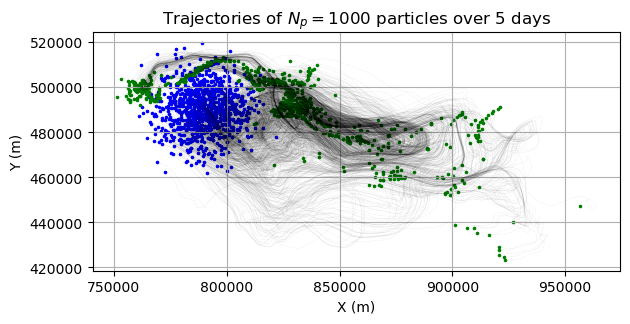

In [8]:
traj_grid = Trajectory(time_interval=T, number_of_particles=Np, stepsize=dt, mode=mode, location=loc, scale=scale)
traj_grid(interpolator)
traj_grid.info()

fig, ax = plt.subplots(1, 1)
traj_grid.plot(ax, **plot_parameters)
traj_grid.scatter(ax, t=0, label="initial position", **scatter_initial_parameters)
traj_grid.scatter(ax, t=-1, label="final position", **scatter_final_parameters)
ax.set_title(f"Trajectories of $N_p = {Np}$ particles over {days} days")
ax.set_xlabel("X (m)")
ax.set_ylabel("Y (m)")
ax.grid()
plt.tight_layout()
plt.show()

## Simulation projected on to the map of the earth

Trajectory with:
Np: 1000 particles
Time: [0, 432000]
Time step: 3600
Initial position: [793013.91425769 481665.42618479]
Mode: map
Check land: False
Velocity shape: (120, 1000)
X, Y shape: (120, 1000)
U, V shape: (120, 1000)
xmin: 753274.2044538852, xmax: 965374.2400548005
ymin: 423113.61751261837, ymax: 524853.8724169292
Distance mean: 178954.3825183537


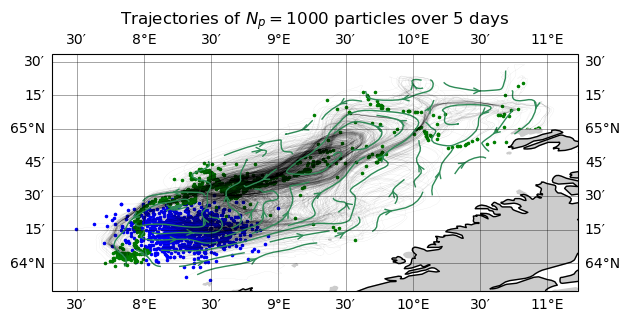

In [9]:
traj_map = Trajectory(time_interval=T, number_of_particles=Np, stepsize=dt, mode="map", location=loc, scale=scale)
traj_map(interpolator)
traj_map.info()

fig, ax = plt.subplots(1,1, subplot_kw={"projection": ccrs.PlateCarree()})

traj_map.init_map(ax, **plot_parameters)
traj_map.scatter(ax, t=0, label="initial position", **scatter_initial_parameters)
traj_map.scatter(ax, t=-1, label="final position", **scatter_final_parameters)
traj_map.streamplot(ax, **streamplot_parameters)

ax.set_title(f"Trajectories of $N_p = {Np}$ particles over {days} days")
ax.set_xlabel("X (m)")
ax.set_ylabel("Y (m)")
ax.grid()
plt.tight_layout()

plt.show()

## ( 2-b )

In [10]:
streamplot_parameters = {"color": "seagreen","density": 1,"linewidth": 0.25,"arrowsize": 1,"arrowstyle": "->"}
scatter_initial_parameters = {"s": 5, "color": "blue"}
scatter_final_parameters = {"s": 5, "color": "green"}
plot_parameters = {"alpha": 0.5, "linewidth": 0.20,"color":"cornflowerblue"}

Trajectory with:
Np: 500 particles
Time: [0, 432000]
Time step: 3600
Initial position: [253508.97521671 464043.12417528]
Mode: map
Check land: True
Velocity shape: (120, 500)
X, Y shape: (120, 500)
U, V shape: (120, 500)
xmin: 216636.90364645814, xmax: 424677.553323434
ymin: 421136.18026289344, ymax: 530928.7490675395
Distance mean: 151434.66373039797
Land percent: 66.8%
Land particles: 120


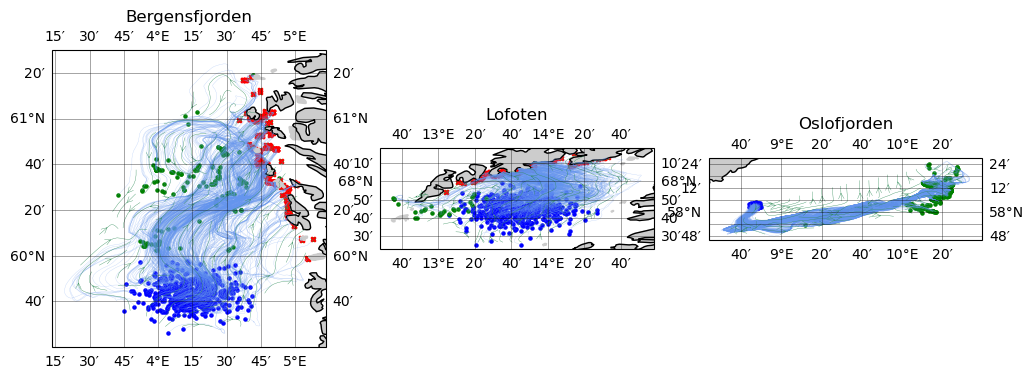

In [11]:
dataset = xr.open_dataset("data/NorKyst-800m.nc")
interpolator = Interpolator(dataset=dataset)

Np=500
days = 5
time_interval = [0, days * 24 * 3600]
dt=3600
mode = "map"

fig, ax = plt.subplots(1,3,figsize=(12, 12), subplot_kw={"projection": ccrs.PlateCarree()})

ax[0].set_title("Bergensfjorden")
bergen, scale = [250000, 460000], 10000
traj_bergen = Trajectory(time_interval=time_interval, stepsize=dt, number_of_particles=Np, mode=mode, location=bergen, scale=scale, check_land=True)
traj_bergen(interpolator)
traj_bergen.info()
traj_bergen.init_map(ax[0], **plot_parameters)
traj_bergen.streamplot(ax[0], **streamplot_parameters)
traj_bergen.scatter(ax[0], t=0, **scatter_initial_parameters)
traj_bergen.scatter(ax[0], t=-1, **scatter_final_parameters)

ax[1].set_title("Lofoten")
lofoten, scale = [1240000, 480000], 10000
traj_lofoten = Trajectory(time_interval=time_interval, stepsize=dt, number_of_particles=Np, mode=mode, location=lofoten, scale=scale, check_land=True)
traj_lofoten(interpolator)
traj_lofoten.init_map(ax[1], **plot_parameters)
traj_lofoten.streamplot(ax[1], **streamplot_parameters)
traj_lofoten.scatter(ax[1], t=0, **scatter_initial_parameters)
traj_lofoten.scatter(ax[1], t=-1, **scatter_final_parameters)

ax[2].set_title("Oslofjorden")
oslo, scale = [200_000, 140_000], 1000
traj_oslo = Trajectory(time_interval=time_interval, stepsize=dt, number_of_particles=Np, mode=mode, location=oslo, scale=scale, check_land=True)
traj_oslo(interpolator)
traj_oslo.init_map(ax[2], **plot_parameters)
traj_oslo.streamplot(ax[2], **streamplot_parameters)
traj_oslo.scatter(ax[2], t=0, **scatter_initial_parameters)
traj_oslo.scatter(ax[2], t=-1, **scatter_final_parameters)
plt.show()

# Problem 3

## ( 3-a )


In [12]:
streamplot_parameters = {"color": "seagreen","density": 0.5,"linewidth": 1,"arrowsize": 1,"arrowstyle": "->"}
plot_parameters = {"color": "cornflowerblue", "alpha": 0.5, "linewidth": 0.1}
scatter_initial_parameters = {"s": 5, "color": "blue"}
scatter_final_parameters = {"s": 5, "color": "green"}

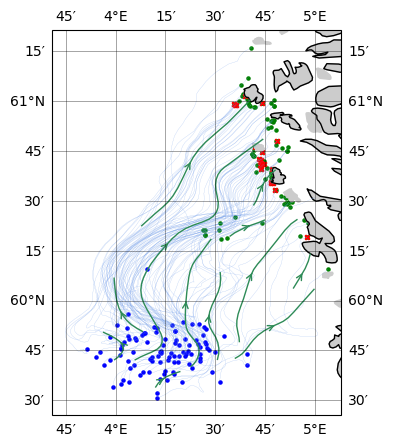

In [13]:
Np=100
days = 3
time_interval = [0, days * 24 * 3600]
dt=3600
mode = "map"
loc, scale = [250_000, 460_000], 10000
time_array = np.arange(0, time_interval[1]-dt, dt)

fig, ax = plt.subplots(figsize=(10,5), subplot_kw={"projection": ccrs.PlateCarree()})
interpolator = Interpolator(dataset=dataset)
traj_bergen = Trajectory(time_interval=time_interval, stepsize=dt, number_of_particles=Np, mode=mode, location=loc, scale=scale, check_land=True)
traj_bergen(interpolator)
traj_bergen.init_map(ax, **plot_parameters)
traj_bergen.plot(ax, **plot_parameters)
traj_bergen.scatter(ax, t=0, **scatter_initial_parameters)
traj_bergen.scatter(ax, t=-1, **scatter_final_parameters)
traj_bergen.streamplot(ax, **streamplot_parameters)
landed_percent = traj_bergen.get_land_percent()

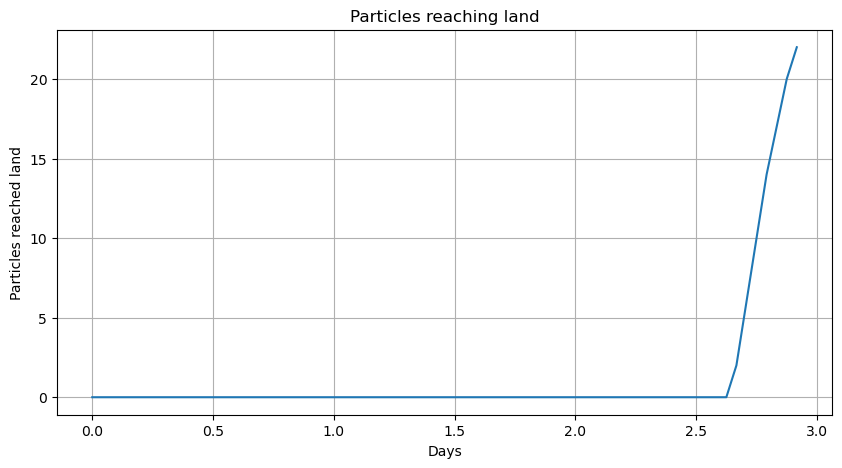

In [15]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(time_array/(3600*24), landed_percent)
ax.set_title('Particles reaching land')
ax.set_xlabel('Days')
ax.set_ylabel('Particles reached land')
ax.grid()
plt.show()

In this example the initial conditions were placed on the west coast, where the wind and ocean current-vectors are pointing towards the shore. As expected the amount of particles reaching land therefore increases with time. After three days, about 40% of the particles have reached shore.

## ( 3-b ) 

With the same initial conditions as above, try a few different windage factors, in
the range from 0 to 0.15, and show how this affects the results. You can for example
look into the percentage of particles that become stranded after three days as a
function of fw. Note that the results may of course depend on where (and when)
you start the particle trajectories, and for some initial conditions no particles will
reach land at all


In [16]:
streamplot_parameters = {"color": "seagreen","density": 0.5,"linewidth": 1,"arrowsize": 1,"arrowstyle": "->"}
plot_parameters = {"color": "cornflowerblue", "alpha": 0.5, "linewidth": 0.1}
scatter_initial_parameters = {"s": 5, "color": "blue"}
scatter_final_parameters = {"s": 5, "color": "green"}

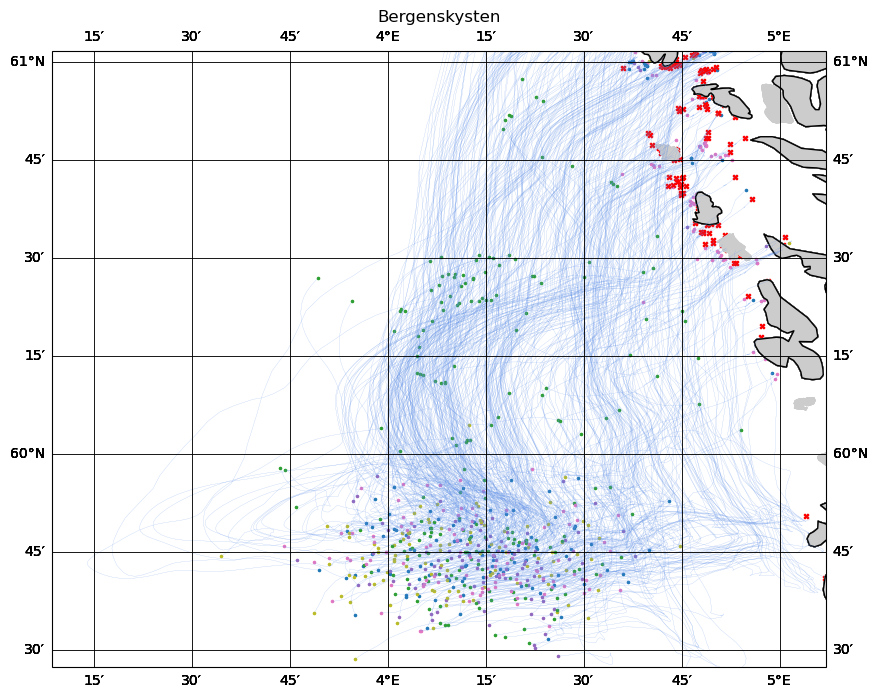

In [21]:
fw = np.linspace(0, 0.15, 5)

fig, ax = plt.subplots(1,1,figsize=(10,8),subplot_kw={"projection": ccrs.PlateCarree()})

landed_percent = []
for w in fw:
    dataset = xr.open_dataset("data/NorKyst-800m.nc")
    interpolator = Interpolator(dataset=dataset, fw=w)
    traj_bergen = Trajectory(time_interval=time_interval, stepsize=dt, number_of_particles=Np, mode=mode, location=loc, scale=scale, check_land=True)
    traj_bergen(interpolator)
    traj_bergen.init_map(ax, **plot_parameters)
    traj_bergen.plot(ax, **plot_parameters)
    traj_bergen.scatter(ax, t=0, **{"label": "Initial Position","s":2.5})
    traj_bergen.scatter(ax, t=-1, **{"label": "Final Position", "s":2.5})

    landed_percent.append(traj_bergen.get_land_percent())

ax.set_title("Bergenskysten")
plt.show()

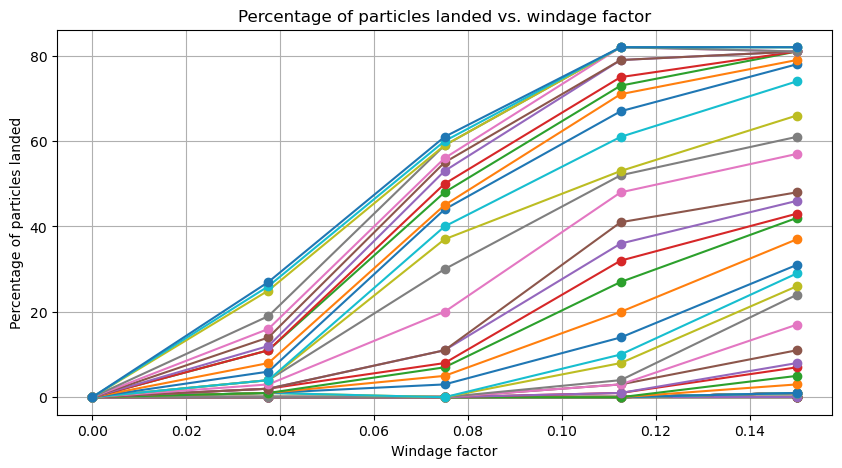

In [20]:

fig, ax = plt.subplots(1,1,figsize=(10, 5))
ax.plot(fw, landed_percent, marker="o")
ax.set_xlabel("Windage factor")
ax.set_ylabel("Percentage of particles landed")
ax.set_title("Percentage of particles landed vs. windage factor")
plt.grid()
plt.show()